In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from global_import import *
from valuation.val import perform_valuation

In [2]:
data = pd.read_csv(f'{DATA_FOLDER}/lagged_comp-fundr-ibes_for_val_1976-2019.csv', index_col = 0)
crsp = pd.read_csv(f'{DATA_FOLDER}/crsp_1959-2019.csv', index_col=0)
beta = pd.read_csv(f'{DATA_FOLDER}/capm_beta_weekly_1-3y_1959-2019.csv', index_col=0)

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
data = data.replace([np.inf, -np.inf], np.nan)
data = data.drop_duplicates(subset=['jdate', 'permno'])

<AxesSubplot:>

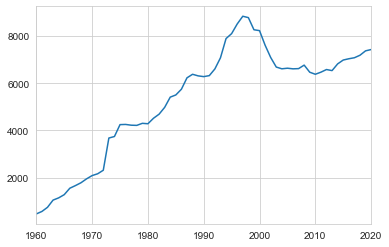

In [4]:
data['year'].value_counts().sort_index().plot()

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from datetime import datetime
from copy import deepcopy

mdfs={}

for year in range(1960, 1999):
    regr_dict = {}
    for pred_yr in [1,2,3,4,5]:
        tr = data.loc[(year <= data['year']) & (data['year'] <= year+19)]
        tryr = tr.dropna(subset = [f'ni_{pred_yr}'])
        X_tr = tryr.drop(['ticker', 'exchcd', 'permno','jdate','year','ni_1', 'ni_2', 'ni_3','ni_4','ni_5'], axis = 1)
        X_tr = X_tr.fillna(0).astype(float)
        y_tr = tryr[f'ni_{pred_yr}']
        y_tr = y_tr.astype(float)
        rf_yr = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=5, n_jobs=-1)
        rf_yr.fit(X_tr, y_tr)
        regr_dict[pred_yr] = deepcopy(rf_yr)
        print(datetime.now(),year, pred_yr, 'IS R2', r2_score(y_tr, rf_yr.predict(X_tr)), X_tr.shape)
        
    ts = data.loc[(year+20 == data['year'])]
    X_ts = ts.drop(['ticker', 'exchcd', 'permno','jdate','year','ni_1', 'ni_2', 'ni_3','ni_4','ni_5'], axis = 1)
    X_ts = X_ts.fillna(0).astype(float)
    
    y_pred_dict = {}
    for pred_yr in [1,2,3,4,5]:
        y_ts = ts[f'ni_{pred_yr}'].fillna(0).astype(float)
        y_pred_dict[pred_yr] = regr_dict[pred_yr].predict(X_ts)
        try:
            print(datetime.now(), year+20, pred_yr, 'OOS R2', \
                 r2_score(y_ts[ts[f'ni_{pred_yr}']>=1], 
                          y_pred_dict[pred_yr][ts[f'ni_{pred_yr}']>=1]),
                 y_ts.shape, y_ts[ts[f'ni_{pred_yr}']>=1].shape)
        except:
            print('no')
        
    mdf_rf = ts[['ticker', 'permno', 'exchcd', 'year', 'jdate', 'be']].copy()
    for pred_yr in [1,2,3,4,5]:
        mdf_rf[f'ni_{pred_yr}'] =  y_pred_dict[pred_yr]
    for i in range(6,11):
        mdf_rf[f'ni_{i}'] =  y_pred_dict[5]
    mdfs[year+20] = deepcopy(mdf_rf)

2020-10-22 23:59:32.226999 1960 1 IS R2 0.9696890906470828 (45887, 301)
2020-10-22 23:59:52.063237 1960 2 IS R2 0.9480125556793527 (44575, 301)
2020-10-23 00:00:11.270673 1960 3 IS R2 0.9345981359449859 (43088, 301)
2020-10-23 00:00:29.439253 1960 4 IS R2 0.9199116086348785 (41547, 301)
2020-10-23 00:00:46.582421 1960 5 IS R2 0.9065208547636299 (39936, 301)
2020-10-23 00:00:46.862854 1980 1 OOS R2 0.9048795829914456 (4283,) (2808,)
2020-10-23 00:00:46.976203 1980 2 OOS R2 0.8107158490048847 (4283,) (2664,)
2020-10-23 00:00:47.091914 1980 3 OOS R2 0.8079981746763176 (4283,) (2327,)
2020-10-23 00:00:47.203649 1980 4 OOS R2 0.5414402256408088 (4283,) (2267,)
2020-10-23 00:00:47.320144 1980 5 OOS R2 0.7098942792571389 (4283,) (2224,)
2020-10-23 00:01:09.366491 1961 1 IS R2 0.9605124265708584 (49547, 301)
2020-10-23 00:01:31.651724 1961 2 IS R2 0.9405176153568936 (47942, 301)
2020-10-23 00:01:54.023552 1961 3 IS R2 0.921809859471738 (46237, 301)
2020-10-23 00:02:15.102708 1961 4 IS R2 0.906

2020-10-23 00:29:13.555832 1971 2 IS R2 0.8129846450945807 (79497, 301)
2020-10-23 00:29:59.616928 1971 3 IS R2 0.7480138770573073 (74442, 301)
2020-10-23 00:30:43.281173 1971 4 IS R2 0.7021642011066556 (70091, 301)
2020-10-23 00:31:24.858856 1971 5 IS R2 0.7263395246408675 (66006, 301)
2020-10-23 00:31:25.189445 1991 1 OOS R2 0.8111745253550884 (6320,) (2815,)
2020-10-23 00:31:25.305795 1991 2 OOS R2 0.7942941577909799 (6320,) (2719,)
2020-10-23 00:31:25.420708 1991 3 OOS R2 0.5609175917078391 (6320,) (3001,)
2020-10-23 00:31:25.539028 1991 4 OOS R2 0.5516124867532882 (6320,) (3039,)
2020-10-23 00:31:25.658390 1991 5 OOS R2 0.5379944123408682 (6320,) (2866,)
2020-10-23 00:32:20.373932 1972 1 IS R2 0.863860070585676 (87941, 301)
2020-10-23 00:33:10.558620 1972 2 IS R2 0.768585551066674 (82296, 301)
2020-10-23 00:33:58.241215 1972 3 IS R2 0.7216516614095483 (77343, 301)
2020-10-23 00:34:42.782988 1972 4 IS R2 0.7013325139683986 (72728, 301)
2020-10-23 00:35:31.895304 1972 5 IS R2 0.7135

2020-10-23 01:20:27.160046 1982 3 IS R2 0.6537808962484644 (97703, 301)
2020-10-23 01:21:17.408174 1982 4 IS R2 0.6244509793866577 (89590, 301)
2020-10-23 01:22:04.644194 1982 5 IS R2 0.5856281966195391 (82394, 301)
2020-10-23 01:22:04.969075 2002 1 OOS R2 0.5871466574062614 (7088,) (3367,)
2020-10-23 01:22:05.086057 2002 2 OOS R2 -4.9225669066684485 (7088,) (3483,)
2020-10-23 01:22:05.203257 2002 3 OOS R2 -0.061652119404056904 (7088,) (3579,)
2020-10-23 01:22:05.317809 2002 4 OOS R2 0.44302656030856624 (7088,) (3344,)
2020-10-23 01:22:05.435434 2002 5 OOS R2 0.6485137537283288 (7088,) (3123,)
2020-10-23 01:23:13.294085 1983 1 IS R2 0.7626483462727979 (118920, 301)
2020-10-23 01:24:14.351109 1983 2 IS R2 0.6457443210057108 (108404, 301)
2020-10-23 01:25:15.188260 1983 3 IS R2 0.652584224586521 (99029, 301)
2020-10-23 01:26:13.928756 1983 4 IS R2 0.652522853827265 (90798, 301)
2020-10-23 01:27:02.659105 1983 5 IS R2 0.6135629878734696 (83461, 301)
2020-10-23 01:27:02.993065 2003 1 OOS R

2020-10-23 02:16:54.436221 1993 4 IS R2 0.6068444261082147 (89935, 301)
2020-10-23 02:17:43.656169 1993 5 IS R2 0.5888215378049848 (82528, 301)
2020-10-23 02:17:43.971523 2013 1 OOS R2 0.6455287804499592 (6533,) (3087,)
2020-10-23 02:17:44.087960 2013 2 OOS R2 0.43850500822394556 (6533,) (3016,)
2020-10-23 02:17:44.205079 2013 3 OOS R2 0.4760903566830278 (6533,) (2674,)
2020-10-23 02:17:44.321246 2013 4 OOS R2 0.6208427817324094 (6533,) (2495,)
2020-10-23 02:17:44.437765 2013 5 OOS R2 0.5301467829505516 (6533,) (2450,)
2020-10-23 02:18:55.809993 1994 1 IS R2 0.7582660699649217 (116815, 301)
2020-10-23 02:20:01.335447 1994 2 IS R2 0.707657047628752 (106304, 301)
2020-10-23 02:20:59.800574 1994 3 IS R2 0.6336870290161176 (96965, 301)
2020-10-23 02:21:53.795753 1994 4 IS R2 0.6089432772373411 (88730, 301)
2020-10-23 02:22:44.101210 1994 5 IS R2 0.5878244665408116 (81587, 301)
2020-10-23 02:22:44.416818 2014 1 OOS R2 0.4207787074056861 (6817,) (3195,)
2020-10-23 02:22:44.530393 2014 2 OOS 

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


2020-10-23 02:38:33.608380 1998 1 IS R2 0.7520866952891814 (106786, 301)
2020-10-23 02:39:33.468816 1998 2 IS R2 0.6799460122241205 (97905, 301)
2020-10-23 02:40:26.744396 1998 3 IS R2 0.6445958737658533 (90305, 301)
2020-10-23 02:41:13.546090 1998 4 IS R2 0.6223336774895525 (80015, 301)
2020-10-23 02:41:55.051939 1998 5 IS R2 0.6055917500941226 (70894, 301)
2020-10-23 02:41:55.373080 2018 1 OOS R2 0.7617358900911739 (7183,) (2905,)
2020-10-23 02:41:55.486881 2018 2 OOS R2 0.7180703883729639 (7183,) (2696,)
2020-10-23 02:41:55.602636 2018 3 OOS R2 -1.2183763817026536 (7183,) (4,)
2020-10-23 02:41:55.719529 2018 4 OOS R2 nan (7183,) (1,)
no


/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [10]:
mdf_rf = pd.concat(mdfs.values())

In [11]:
mdf_rf = mdf_rf.sort_values(by=['permno', 'jdate'])

In [12]:
mdf_rf[mdf_rf.ticker=='TSLA']

,ticker,permno,exchcd,year,jdate,be,ni_1,ni_2,ni_3,ni_4,ni_5,ni_6,ni_7,ni_8,ni_9,ni_10
692395,TSLA,93436,3.0,2010,2010-06-30,NaN,28.711807,30.345887,25.750219,24.571279,19.302648,19.302648,19.302648,19.302648,19.302648,19.302648
692392,TSLA,93436,3.0,2011,2011-06-30,207.048,30.619149,30.502099,29.110508,26.161481,22.137074,22.137074,22.137074,22.137074,22.137074,22.137074
692389,TSLA,93436,3.0,2012,2012-06-30,224.045,35.225982,29.878035,29.993716,29.065579,25.817069,25.817069,25.817069,25.817069,25.817069,25.817069
692386,TSLA,93436,3.0,2013,2013-06-30,124.700,33.954056,32.119949,29.237387,27.517502,25.099676,25.099676,25.099676,25.099676,25.099676,25.099676
692383,TSLA,93436,3.0,2014,2014-06-30,673.941,32.431216,31.814242,30.027433,-1070.609161,28.038643,28.038643,28.038643,28.038643,28.038643,28.038643
692380,TSLA,93436,3.0,2015,2015-06-30,969.906,33.855384,27.522670,29.686266,-10.771434,26.628550,26.628550,26.628550,26.628550,26.628550,26.628550
692377,TSLA,93436,3.0,2016,2016-06-30,1130.989,37.343768,28.053482,29.673946,32.285435,33.019387,33.019387,33.019387,33.019387,33.019387,33.019387
692374,TSLA,93436,3.0,2017,2017-06-30,4761.695,31.924925,27.761088,31.357752,38.919601,204.684297,204.684297,204.684297,204.684297,204.684297,204.684297
692371,TSLA,93436,3.0,2018,2018-06-30,4237.312,28.319278,30.088603,34.904791,35.322911,279.215216,279.215216,279.215216,279.215216,279.215216,279.215216


In [13]:
comp = mdf_rf
comp['jdate'] = pd.to_datetime(comp['jdate'])
comp.permno = comp.permno.astype(int)

beta['date']=pd.to_datetime(beta['DATE'].astype(str))
beta['jdate']=beta['date']+MonthEnd(0)
beta['permno'] = beta.index
beta = beta.drop_duplicates(subset=['permno', 'jdate'])

In [14]:
FF = pd.read_csv(f'{PROJECT_FOLDER}/lookup_tables/FF3.csv')
FF['date'] = FF['Unnamed: 0']
FF['date'] = pd.to_datetime(FF['date'].astype(str), format='%Y%m%d')
FF['jdate'] = FF['date']+MonthEnd(0)
FF = FF[['jdate', 'date', 'RF']]
FF['RF'] = (1+FF['RF']/100).pow(365)-1

beta = beta.merge(FF[['jdate', 'RF']],  on=['jdate'])
beta = beta.drop_duplicates(subset=['permno', 'jdate'])

In [15]:
comp.sort_values(['permno','jdate'], ascending = [True,True], inplace=True)
crsp['logret'] = np.log(1+crsp['retadj'])
crsp['termlogret'] = crsp.groupby('permno')['logret'].transform('sum') - crsp.groupby('permno')['logret'].transform('cumsum') + np.log(1-0.35) 
crsp['termcumret'] = np.exp(crsp['termlogret'])-1
crsp1 = crsp.copy()

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [16]:
for x in ['logret_3', 'logret_6', 'logret_12', 'logret_24', 
      'logret_36', 'logret_48', 'logret_60']:
    crsp1.loc[crsp1[x].isnull(), x] = crsp1['termlogret']


for x in ['cumret_3', 'cumret_6', 'cumret_12', 'cumret_24', 
      'cumret_36', 'cumret_48', 'cumret_60']:
    crsp1.loc[crsp1[x].isnull(), x] = crsp1['termcumret']

In [17]:
valdf = comp.merge(beta, on=['jdate', 'permno'])
valdf = perform_valuation(valdf, n=5, rp=0.07, tg=0.05)
valdf = valdf[['permno', 'year', 'PV', 'be']]
valdf.year = valdf.year + 1
val_crsp_mdf = valdf.merge(crsp1, on=['year', 'permno'])
val_crsp_mdf['vt'] = val_crsp_mdf['PV']*1000
val_crsp_mdf['be'] = val_crsp_mdf['be']*1000

In [18]:
val_df1 = val_crsp_mdf[['permno', 'ticker',  'exchcd', 'year', 'jdate', 'exchcd',
                        'vt','me', 'be', 'prc',
                        'logret_3', 'logret_6', 'logret_24', 'cumret_3', 'cumret_6', 'cumret_24',
                        'logret_12', 'logret_36', 'logret_48', 'logret_60', 
                        'cumret_12', 'cumret_36', 'cumret_48', 'cumret_60',]]
val_df1.sort_values(['permno','jdate'], ascending = [True,False], inplace=True)

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
val_df2 = val_df1.copy()
for m in [3, 6, 12, 24, 36, 48, 60]:
    val_df2[f'vt+{m}'] = val_df1.groupby('permno')['vt'].shift(m)
    val_df2[f'me+{m}'] = val_df1.groupby('permno')['me'].shift(m)
    val_df2[f'be+{m}'] = val_df1.groupby('permno')['be'].shift(m)

In [20]:
val_df3 = val_df2.copy()
for m in [3, 6, 12, 24, 36, 48, 60]:
    val_df3['vt'] = np.log(val_df2.vt)
    val_df3[f'vt+{m}'] = np.log(val_df2[f'vt+{m}'].astype(float))
    val_df3['me'] = np.log(val_df2['me'].astype(float))
    val_df3[f'me+{m}'] = np.log(val_df2[f'me+{m}'].astype(float))
    val_df3[f'r_t+{m}'] = val_df3[f'logret_{m}']
    val_df3[f'r*_t+{m}'] = val_df3[f'vt+{m}'] -  val_df3[f'vt']
    val_df3[f'r_unchg+{m}'] = - (1-0.975) * (val_df3['me'] -  val_df3['vt'])
    val_df3[f'r_chg+{m}'] = 0.975 * ( (val_df3[f'me+{m}'] -  val_df3[f'vt+{m}']) - ((val_df3[f'me'] -  val_df3['vt'])) )
    

/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
/Users/mmw/Installations/venvs/mlval/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [21]:
val_df3 = val_df3[(val_df3.year >=1980) & (val_df3.year<=2020)]
val_df3 = val_df3.drop_duplicates(subset=['permno', 'jdate'])

In [22]:
val_df3['misp'] = val_df3['me'] - val_df3['vt']
val_df3 = val_df3.dropna(subset=['misp', 'r_t+60'])
val_df3 = val_df3.replace([np.inf, -np.inf], np.nan)

In [23]:
val_df3[(val_df3.ticker=='WMT') ]

,permno,ticker,exchcd,year,jdate,exchcd,vt,me,be,prc,logret_3,logret_6,logret_24,cumret_3,cumret_6,cumret_24,logret_12,logret_36,logret_48,logret_60,cumret_12,cumret_36,cumret_48,cumret_60,vt+3,me+3,be+3,vt+6,me+6,be+6,vt+12,me+12,be+12,vt+24,me+24,be+24,vt+36,me+36,be+36,vt+48,me+48,be+48,vt+60,me+60,be+60,r_t+3,r*_t+3,r_unchg+3,r_chg+3,r_t+6,r*_t+6,r_unchg+6,r_chg+6,r_t+12,r*_t+12,r_unchg+12,r_chg+12,r_t+24,r*_t+24,r_unchg+24,r_chg+24,r_t+36,r*_t+36,r_unchg+36,r_chg+36,r_t+48,r*_t+48,r_unchg+48,r_chg+48,r_t+60,r*_t+60,r_unchg+60,r_chg+60,misp
733803,55976,WMT,1,2019,2019-12-31,1,20.888929,19.636097,82131000.0,118.839996,-0.430783,-0.430783,-0.430783,-0.350000,-0.350000,-0.350000,-0.430783,-0.430783,-0.430783,-0.430783,-0.350000,-0.350000,-0.350000,-0.350000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-0.430783,NaN,0.031321,NaN,-1.252831
733802,55976,WMT,1,2019,2019-11-30,1,20.888929,19.640701,82131000.0,119.089996,-0.428435,-0.428435,-0.428435,-0.348472,-0.348472,-0.348472,-0.428435,-0.428435,-0.428435,-0.428435,-0.348472,-0.348472,-0.348472,-0.348472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-0.428435,NaN,0.031206,NaN,-1.248227
733801,55976,WMT,1,2019,2019-10-31,1,20.888929,19.625216,82131000.0,117.260002,-0.412949,-0.412949,-0.412949,-0.338304,-0.338304,-0.338304,-0.412949,-0.412949,-0.412949,-0.412949,-0.338304,-0.338304,-0.338304,-0.338304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-0.412949,NaN,0.031593,NaN,-1.263713
733800,55976,WMT,1,2019,2019-09-30,1,20.888929,19.637253,82131000.0,118.680000,0.005797,-0.424986,-0.424986,0.005814,-0.346221,-0.346221,-0.424986,-0.424986,-0.424986,-0.424986,-0.346221,-0.346221,-0.346221,-0.346221,20.888929,19.636097,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005797,0.000000,0.031292,-0.001126,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-0.424986,NaN,0.031292,NaN,-1.251676
733799,55976,WMT,1,2019,2019-08-31,1,20.888929,19.602962,82131000.0,114.260002,0.041403,-0.387032,-0.387032,0.042272,-0.320930,-0.320930,-0.387032,-0.387032,-0.387032,-0.387032,-0.320930,-0.320930,-0.320930,-0.320930,20.888929,19.640701,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041403,0.000000,0.032149,0.036796,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-0.387032,NaN,0.032149,NaN,-1.285967
733798,55976,WMT,1,2019,2019-07-31,1,20.888929,19.568414,82131000.0,110.379997,0.065093,-0.347856,-0.347856,0.067258,-0.293800,-0.293800,-0.347856,-0.347856,-0.347856,-0.347856,-0.293800,-0.293800,-0.293800,-0.293800,20.888929,19.625216,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065093,0.000000,0.033013,0.055382,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-0.347856,NaN,0.033013,NaN,-1.320515
733797,55976,WMT,1,2019,2019-06-30,1,20.888929,19.569410,82131000.0,110.489998,0.076134,0.081931,-0.348852,0.079107,0.085381,-0.294503,-0.348852,-0.348852,-0.348852,-0.348852,-0.294503,-0.294503,-0.294503,-0.294503,20.888929,19.637253,82131000.0,20.888929,19.636097,82131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076134,0.000000,0.0

In [25]:
val_df3 = val_df3.replace([np.inf, -np.inf], np.nan)
val_df3.to_csv(f'{DATA_FOLDER}/decomp_dcf5y_RF_rolling_1980_2019.csv')

In [24]:
val_df3.describe()

,permno,exchcd,year,exchcd,vt,me,be,prc,logret_3,logret_6,logret_24,cumret_3,cumret_6,cumret_24,logret_12,logret_36,logret_48,logret_60,cumret_12,cumret_36,cumret_48,cumret_60,vt+3,me+3,be+3,vt+6,me+6,be+6,vt+12,me+12,be+12,vt+24,me+24,be+24,vt+36,me+36,be+36,vt+48,me+48,be+48,vt+60,me+60,be+60,r_t+3,r*_t+3,r_unchg+3,r_chg+3,r_t+6,r*_t+6,r_unchg+6,r_chg+6,r_t+12,r*_t+12,r_unchg+12,r_chg+12,r_t+24,r*_t+24,r_unchg+24,r_chg+24,r_t+36,r*_t+36,r_unchg+36,r_chg+36,r_t+48,r*_t+48,r_unchg+48,r_chg+48,r_t+60,r*_t+60,r_unchg+60,r_chg+60,misp
count,1.591824e+06,1.591824e+06,1.591824e+06,1.591824e+06,1.591824e+06,1.591238e+06,1.461109e+06,1.591238e+06,1.591806e+06,1.591792e+06,1.591724e+06,1.591824e+06,1.591824e+06,1.591824e+06,1.591768e+06,1.591688e+06,1.591652e+06,1.591626e+06,1.591824e+06,1.591824e+06,1.591824e+06,1.591824e+06,1.540717e+06,1.552342e+06,1.425912e+06,1.490659e+06,1.514238e+06,1.391452e+06,1.393850e+06,1.440547e+06,1.324904e+06,1.233272e+06,1.306445e+06,1.203635e+06,1.097718e+06,1.187018e+06,1.094810e+06,986855.000000,1.080064e+06,9.964950e+05,897343.000000,983708.000000,9.079310e+05,1.591806e+06,1.540717e+06,1.591238e+06,1.539882e+06,1.591792e+06,1.490659e+06,1.591238e+06,1.489882e+06,1.591768e+06,1.393850e+06,1.591238e+06,1.393206e+06,1.591724e+06,1.233272e+06,1.591238e+06,1.232718e+06,1.591688e+06,1.097718e+06,1.591238e+06,1.097192e+06,1.591652e+06,986855.000000,1.591238e+06,986368.000000,1.591626e+06,897343.000000,1.591238e+06,896923.000000,1.591238e+06
mean,5.728632e+04,2.043221e+00,1.999708e+03,2.043221e+00,1.299058e+01,1.237026e+01,1.685544e+06,3.258491e+01,-7.959620e-03,-1.589219e-02,-4.319445e-02,2.604367e-02,5.204510e-02,2.166847e-01,-2.689539e-02,-5.929604e-02,-6.693065e-02,-7.468536e-02,1.101403e-01,3.106013e-01,4.170229e-01,5.288393e-01,1.300097e+01,1.239196e+01,1.709234e+06,1.301174e+01,1.241341e+01,1.733554e+06,1.303400e+01,1.246010e+01,1.783292e+06,1.313657e+01,1.255711e+01,1.880139e+06,1.323848e+01,1.265172e+01,1.991260e+06,13.335340,1.275453e+01,2.125473e+06,13.443296,12.853226,2.272641e+06,-7.959620e-03,2.080467e-02,1.552692e-02,-1.296268e-02,-1.589219e-02,4.268956e-02,1.552692e-02,-2.652612e-02,-2.689539e-02,8.982144e-02,1.552692e-02,-4.939772e-02,-4.319445e-02,2.027442e-01,1.552692e-02,-9.532286e-02,-5.929604e-02,3.190333e-01,1.552692e-02,-1.434996e-01,-6.693065e-02,0.433140,1.552692e-02,-0.180523,-7.468536e-02,0.552892,1.552692e-02,-0.222072,-6.210768e-01
std,2.627206e+04,9.456923e-01,1.075248e+01,9.456923e-01,2.034076e+00,2.293479e+00,8.239317e+06,8.459649e+02,2.650949e-01,3.791749e-01,7.713512e-01,2.926363e-01,4.441725e-01,1.277488e+00,5.446796e-01,9.310283e-01,1.062235e+00,1.173211e+00,8.857993e-01,1.647509e+00,2.156764e+00,3.045983e+00,2.030666e+00,2.293388e+00,8.288776e+06,2.026955e+00,2.293496e+00,8.338494e+06,2.018301e+00,2.291304e+00,8.437221e+06,2.022752e+00,2.286103e+00,8.562781e+06,2.032576e+00,2.287046e+00,8.724575e+06,2.035378,2.287915e+00,9.067653e+06,2.029818,2.290828,9.446395e+06,2.650949e-01,3.183724e-01,4.179725e-02,4.091976e-01,3.791749e-01,4.544651e-01,4.179725e-02,5.803193e-01,5.446796e-01,6.556528e-01,4.179725e-02,8.220245e-01,7.713512e-01,8.813811e-01,4.179725e-02,1.095265e+00,9.310283e-01,1.010065e+00,4.179725e-02,1.228838e+00,1.062235e+00,1.086478,4.179725e-02,1.298333,1.173211e+00,1.116667,4.179725e-02,1.336246,1.671890e+00
min,1.000100e+04,1.000000e+00,1.981000e+03,1.000000e+00,6.827981e+00,1.313388e+00,1.000000e+00,1.050000e-02,-9.478570e+00,-1.091677e+01,-1.515275e+01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.244822e+01,-1.684451e+01,-1.874448e+01,-1.874448e+01,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,6.827981e+00,1.313388e+00,1.000000e+00,6.827981e+00,1.313388e+00,1.000000e+00,6.827981e+00,1.313388e+00,1.000000e+00,6.827981e+00,1.313388e+00,1.000000e+00,7.102868e+00,1.313388e+00,1.000000e+00,7.102868,1.313388e+00,1.000000e+00,7.102868,1.313388,1.000000e+00,-9.478570e+00,-1.462648e+01,-2.058935e-01,-8.340798e+00,-1.091677e+01,-1.462648e+01,-2.058935e-01,